In [31]:
import orekit
import numpy as np

vm = orekit.initVM()
print ('Java version:',vm.java_version)
print ('Orekit version:', orekit.VERSION)

from orekit.pyhelpers import setup_orekit_curdir, download_orekit_data_curdir
setup_orekit_curdir()

from org.orekit.utils import Constants

from scenarios.utils.utility import get_vel, get_vels, mass_fraction, rocket_equation


Java version: 1.8.0_382
Orekit version: 12.0.1
File or folder: /home/chris/git/space/src/orekit-data.zip  not found


        The Orekit library relies on some external data for physical models. 
        Typical data are the Earth Orientation Parameters and the leap seconds history, 
        both being provided by the IERS or the planetary ephemerides provided by JPL. 
        Such data is stored in text or binary files with specific formats that Orekit knows 
        how to read, and needs to be provided for the library to work.

        You can download a starting file with this data from the orekit gitlab at:
        https://gitlab.orekit.org/orekit/orekit-data

        or by the function:
        orekit.pyhelpers.download_orekit_data_curdir()

        


In [32]:

###

RE = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
MU = Constants.WGS84_EARTH_MU

print(f'using Constants.WGS84_EARTH_EQUATORIAL_RADIUS {Constants.WGS84_EARTH_EQUATORIAL_RADIUS} as RE')
print(f'using Constants.WGS84_EARTH_MU {Constants.WGS84_EARTH_MU} as MU')

g_test = MU / RE**2

print(f'g (m/s^2) = {g_test}')


## TODO: Reconsider MUs ?

MU_JPL = Constants.JPL_SSD_EARTH_GM

print(f'mu = {MU}')
print(f'mu_jpl = {MU_JPL}')
print(f'mu - mujpl = {MU - MU_JPL}')

RM = Constants.MOON_EQUATORIAL_RADIUS


using Constants.WGS84_EARTH_EQUATORIAL_RADIUS 6378137.0 as RE
using Constants.WGS84_EARTH_MU 398600441800000.0 as MU
g (m/s^2) = 9.7982854791873
mu = 398600441800000.0
mu_jpl = 398600436738211.56
mu - mujpl = 5061788.4375


In [33]:
###

h_geo = 36000e3 # m

R_geo = h_geo + RE

v_geo = get_vel( R_geo, R_geo, MU )

print(f'v_geo (km/s) = {v_geo/1000}')




v_geo (km/s) = 3.066888291825575


In [34]:
MU_L = Constants.JPL_SSD_MOON_GM

# https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
RE_MP = 363104e3
RE_MA = 405696e3
RE_M = np.mean([RE_MA,RE_MP])
print(f'RE_M (km) = {RE_M/1000}')


# TODO: check me: apogee of low earth LTI orbit
R_a_LTI = 384400e3

(vp_lti,va_lti) = get_vels( R_geo, R_a_LTI, MU )

print(f'vp_lti (km/s) = {vp_lti/1000}, va_lti (km/s) = {va_lti/1000}')



RE_M (km) = 384400.0
vp_lti (km/s) = 4.116267245518918, va_lti (km/s) = 0.45379744344228246


In [35]:
### GEO to Lunar Transfer (2.5km/s from bard = .7 circ + 1.3 raise + .5 inc)

v_inf_geo = np.sqrt( 2*MU/R_geo )

(vp_geo2lti,va_geo2lti) = get_vels( R_geo, R_a_LTI, MU )

print(f'vp_geo2lti (km/s) = {vp_geo2lti/1000}, va_geo2lti (km/s) = {va_geo2lti/1000}')

dv_geo2lti = vp_geo2lti - v_geo
dv_geo2inf = v_inf_geo  - v_geo

print(f'DV GEO 2 LTI = vp_geo2lti - v_geo (m/s) = {dv_geo2lti}')
print(f'DV GEO 2 INF = vp_inf_geo - v_geo (m/s) = {dv_geo2inf}')


vp_geo2lti (km/s) = 4.116267245518918, va_geo2lti (km/s) = 0.45379744344228246
DV GEO 2 LTI = vp_geo2lti - v_geo (m/s) = 1049.3789536933427
DV GEO 2 INF = vp_inf_geo - v_geo (m/s) = 1270.3467247574072


In [36]:
### Lunar Capture (640 m/s from bard to 100 km circ [+ 120 m/s for direct transfers])
# : (chatGPT says 1.5 - 2 km/s)

dv_lti2llo = 760

h_llo = 100e3

v_llo = get_vel( h_llo+RM, h_llo+RM, MU_L )

(vp_l2s,va_l2s) = get_vels( RM, h_llo+RM, MU_L )

# https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
print(f'moon radius = {RM}')
print(f'MU_L (m^3/s^2) = {MU_L*10**-12} *10^12')
print(f'MU (Gkm^3/s^2) = {MU * 10**-9 * 10**-6}, MU_L (Gkm^3/s^2) = {MU_L * 10**-9 * 10**-6}')
print(f'escape velocity = 2.38 km/s (11.2 for earth)')
v_ls = 0 # once every 30 days right ?

# Sidereal rotation period (hrs)	655.720
w_L = 2*np.pi / (655.72*3600)
v_ls = w_L * RM

print(f'v_ls = {v_ls}')
print(f'vp_l2s = {vp_l2s}')
print(f'va_l2s = {va_l2s}')
print(f'v_llo = {v_llo}')

dv_ls2l2s = vp_l2s - v_ls
print(f'DV LS 2 L2S = vp_l2s - v_ls (m/s) = {dv_ls2l2s}')

dv_l2s2llo = v_llo - va_l2s
print(f'DV L2S 2 LLO = v_llo - va_l2s (m/s) = {dv_l2s2llo}')

print(f'RM (km) = {RM/1000}')


# # distribute to get 2km/s
# dv_geo2lti = 1200
# dv_lti2llo = 800

# # distribute to get 2km/s
# dv_l2s2llo = 200
# dv_ls2l2s = 1800


# Ballistic
dv_geo2lti = 1200
dv_lti2llo = 0

# Ballistic
dv_l2s2llo = 20 # 20 m/s is good as gets
dv_ls2l2s = 1680 # 1700 m/s is good as gets



print(f'GEO 2 LTI : {dv_geo2lti:10.0f} \t lunar injection')
print(f'LTI 2 LLO : {dv_lti2llo:10.0f} \t lunar orbit capture')
print(f'LLO 2 L2S : {dv_l2s2llo:10.0f} \t lunar descent burn')
print(f'L2S 2 LS  : {dv_ls2l2s:10.0f} \t lunar landing burn')



moon radius = 1737400.0
MU_L (m^3/s^2) = 4.902798458429648 *10^12
MU (Gkm^3/s^2) = 0.39860044180000004, MU_L (Gkm^3/s^2) = 0.004902798458429647
escape velocity = 2.38 km/s (11.2 for earth)
v_ls = 4.624435799449381
vp_l2s = 1703.1899706600493
va_l2s = 1610.4943153503698
v_llo = 1633.5038575843078
DV LS 2 L2S = vp_l2s - v_ls (m/s) = 1698.5655348605999
DV L2S 2 LLO = v_llo - va_l2s (m/s) = 23.009542233937964
RM (km) = 1737.4
GEO 2 LTI :       1200 	 lunar injection
LTI 2 LLO :          0 	 lunar orbit capture
LLO 2 L2S :         20 	 lunar descent burn
L2S 2 LS  :       1680 	 lunar landing burn


In [37]:
###


# Isp = 350 # Lox Methane
Isp = 450
g0 = 9.8
m_spacecraft = 10e3
# m_dump = 10e3
m_dump = np.linspace(0, 20e3, num=10)

m_l2s2ls = m_spacecraft * mass_fraction( dv_ls2l2s, Isp, g0 )
print(f'm_l2s2ls = {m_l2s2ls}')

m_llo_return = m_l2s2ls * mass_fraction( dv_l2s2llo, Isp, g0 )
print(f'm_llo = {m_llo_return}')

m_lti2llo = m_llo_return * mass_fraction( dv_lti2llo, Isp, g0 )
print(f'm_lti2llo = {m_lti2llo}')

m_geo_return = m_lti2llo * mass_fraction( dv_geo2lti, Isp, g0 )
print(f'm_geo_return = {m_geo_return}')

m_geo_arrive = m_geo_return + m_dump
print(f'm_geo_arrive = {m_geo_arrive}')

m_lti2geo = m_geo_arrive * mass_fraction( dv_geo2lti, Isp, g0 )
print(f'm_lti2geo = {m_lti2geo}')

m_llo_depart = m_lti2geo * mass_fraction( dv_lti2llo, Isp, g0 )
print(f'm_llo_depart = {m_llo_depart}')

m_l2s = m_llo_depart * mass_fraction( dv_l2s2llo, Isp, g0 )
print(f'm_l2s = {m_l2s}')

m_ls = m_l2s * mass_fraction( dv_ls2l2s, Isp, g0 )
print(f'm_ls = {m_ls}')



m_l2s2ls = 14636.779048023556
m_llo = 14703.309747587895
m_lti2llo = 14703.309747587895
m_geo_return = 19301.47397731248
m_geo_arrive = [19301.47397731 21523.69619953 23745.91842176 25968.14064398
 28190.3628662  30412.58508842 32634.80731065 34857.02953287
 37079.25175509 39301.47397731]
m_lti2geo = [25337.62153504 28254.79903659 31171.97653815 34089.1540397
 37006.33154125 39923.50904281 42840.68654436 45757.86404591
 48675.04154747 51592.21904902]
m_llo_depart = [25337.62153504 28254.79903659 31171.97653815 34089.1540397
 37006.33154125 39923.50904281 42840.68654436 45757.86404591
 48675.04154747 51592.21904902]
m_l2s = [25452.79234417 28383.22972068 31313.66709719 34244.1044737
 37174.54185021 40104.97922672 43035.41660322 45965.85397973
 48896.29135624 51826.72873275]
m_ls = [37254.68976969 41543.90620909 45833.12264849 50122.3390879
 54411.5555273  58700.7719667  62989.9884061  67279.20484551
 71568.42128491 75857.63772431]


In [38]:
###


m_spacecraft = m_l2s2ls
m_burned = m_ls - m_dump - m_spacecraft

mass_ratio = m_burned / (m_burned + m_spacecraft)
print(f'm_spacecraft = {m_spacecraft}')
print(f'm_burned = {m_burned}')
print(f'm_dump = {m_dump}')
print(f'm_burned / (m_burned + m_spacecraft) = {m_burned / (m_burned + m_spacecraft)}')

print(f'm_burned / (m_burned + m_dump) = {m_burned / (m_burned + m_dump)}')


m_spacecraft = 14636.779048023556
m_burned = [22617.91072166 24684.90493884 26751.89915602 28818.89337321
 30885.88759039 32952.88180757 35019.87602475 37086.87024193
 39153.86445911 41220.85867629]
m_dump = [    0.          2222.22222222  4444.44444444  6666.66666667
  8888.88888889 11111.11111111 13333.33333333 15555.55555556
 17777.77777778 20000.        ]
m_burned / (m_burned + m_spacecraft) = [0.6071158  0.62776825 0.6463579  0.66317909 0.67847272 0.69243784
 0.70524033 0.7170196  0.72789359 0.7379628 ]
m_burned / (m_burned + m_dump) = [1.         0.91741139 0.85753316 0.81213015 0.77651945 0.74784148
 0.72425133 0.70450534 0.68773467 0.67331396]


In [39]:


m_burned_cons = np.array([46312.4717773,  49594.59122122, 52876.71066515, 56158.83010907, 59440.94955299, 62723.06899692, 66005.18844084, 69287.30788477, 72569.42732869, 75851.54677262])

m_dump_cons = np.array([    0.,          2222.22222222,  4444.44444444,  6666.66666667,  8888.88888889, 11111.11111111, 13333.33333333, 15555.55555556, 17777.77777778, 20000.        ])


m_burned_norm = np.array([34898.19641585, 37624.93464385, 40351.67287185, 43078.41109985, 45805.14932784, 48531.88755584, 51258.62578384, 53985.36401184, 56712.10223984, 59438.84046784])
m_dump_norm = np.array([    0.,          2222.22222222,  4444.44444444,  6666.66666667,  8888.88888889, 11111.11111111, 13333.33333333, 15555.55555556, 17777.77777778, 20000.  ])

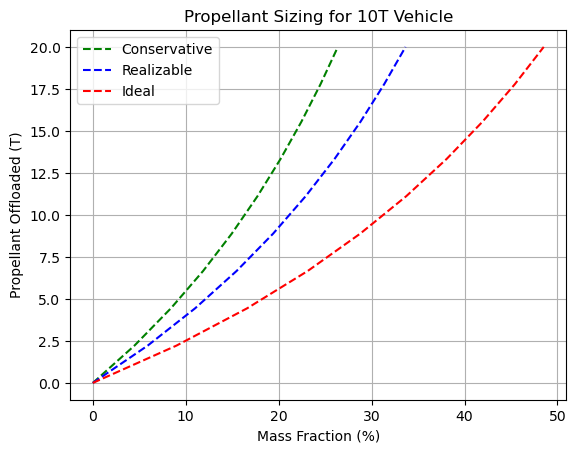

In [41]:
import matplotlib.pyplot as plt

# Plotting
# plt.plot( m_burned/1000, m_dump/1000, marker='o', linestyle='-' )
# plt.xlabel('Propellant Burned (T)')

# plt.plot( m_dump_ideal / m_burned_ideal * 100, m_dump_ideal/1000, marker=None, linestyle='--', color='r' )
plt.plot( m_dump_cons / m_burned_cons * 100, m_dump_cons/1000, marker=None, linestyle='--', color='g' )
plt.plot( m_dump_norm / m_burned_norm * 100, m_dump_norm/1000, marker=None, linestyle='--', color='b' )
plt.plot( m_dump / m_burned * 100, m_dump/1000, marker=None, linestyle='--', color='r' )
plt.xlabel('Mass Fraction (%)')
plt.legend(['Conservative','Realizable','Ideal'])


# Adding labels and title
plt.ylabel('Propellant Offloaded (T)')
title = 'Propellant Sizing for 10T Vehicle'
plt.title(title)
plt.grid()

# Display the plot
plt.savefig(title.replace(' ','_') + '.png')
plt.show()


